In [108]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import *
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam 
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# Label-to-letter mapping
LABEL_TO_LETTER = {
    0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f',
    6: 'g', 7: 'h', 8: 'i', 9: 'k', 10: 'l', 11: 'm',
    12: 'n', 13: 'o', 14: 'p', 15: 'q', 16: 'r', 17: 's',
    18: 't', 19: 'u', 20: 'v', 21: 'w', 22: 'x', 23: 'y'
}

# Inverse mapping: letter -> label
LETTER_TO_LABEL = {v: k for k, v in LABEL_TO_LETTER.items()}

# General project path (relative, NOT absolute)
project_path = os.path.join('train')  # assumes a folder 'train/' in current directory

images = []
labels = []

# Importing all images and assigning labels
for filename in os.listdir(project_path):
    if filename.startswith('.'):
        continue  # Skip hidden files like .DS_Store

    filepath = os.path.join(project_path, filename)
    basename = os.path.splitext(filename)[0]  # e.g., 'a_1', 'b_12'

    first_char = basename[0].lower()
    if first_char in LETTER_TO_LABEL:
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            labels.append(LETTER_TO_LABEL[first_char])

# Convert lists to arrays
images = np.array(images)
labels = np.array(labels)

print('Images shape:', images.shape)
print('Labels shape:', labels.shape)

# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(
    images, labels, train_size=0.8, test_size=0.2, random_state=1
)


labels shape:
(960,)
images shape:
(960, 400, 300)


In [104]:
resnet_model = Sequential()

#import the ResNet50 model and include the weights from imagenet
#input shape is shape of image. ResNet50 requires 3 channels input
base_model= ResNet50(include_top=False,
                   input_shape=(400,300,3),
                   pooling='avg',
                   weights='imagenet')
base_model.trainable = False


#add a Dense layer with 64 neurons and an output layer with 24 neurons using softmax activation, for classification
model = Sequential([
    base_model.output,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(24, activation='softmax'),
])

/opt/anaconda3/envs/neuralnet/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [66]:
#show the model parameters
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_9 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_10 (Dense)             (None, 24)                1560      
Total params: 23,720,408
Trainable params: 132,696
Non-trainable params: 23,587,712
_________________________________________________________________


In [67]:
#use categorical_crossentropy, and improve accuracy, using Adam optimizer 
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [155]:
X_train = X_train
X_val = X_val

#one hot encoding the outputs
onehot_encoder = OneHotEncoder(sparse=False)
Y_train_reshape = Y_train.reshape(Y_train.shape[0], 1)
Y_val_reshape = Y_val.reshape(Y_val.shape[0], 1)

onehot_encoded_train = onehot_encoder.fit_transform(Y_train_reshape)
onehot_encoded_val = onehot_encoder.fit_transform(Y_val_reshape)

In [156]:
#copying the grayscale channel 3 times since ResNet50 requires input of 3 channels
#this mimics rgb channels
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, -1)
X_val_rgb = np.repeat(X_val[..., np.newaxis], 3, -1)

In [42]:
#train model with 10 epochs
history = model.fit(x=X_train_rgb,y=onehot_encoded_train,validation_data=(X_val_rgb,onehot_encoded_val), epochs=10)

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 1162s 2s/step - loss: 2.7341 - accuracy: 0.2344 - val_loss: 2.8993 - val_accuracy: 0.1719
Epoch 2/10
768/768 [==============================] - 1113s 1s/step - loss: 1.7221 - accuracy: 0.6549 - val_loss: 2.6106 - val_accuracy: 0.2344
Epoch 3/10
768/768 [==============================] - 1120s 1s/step - loss: 1.1101 - accuracy: 0.8255 - val_loss: 2.3893 - val_accuracy: 0.2812
Epoch 4/10
768/768 [==============================] - 1112s 1s/step - loss: 0.7041 - accuracy: 0.9193 - val_loss: 2.2990 - val_accuracy: 0.2552
Epoch 5/10
768/768 [==============================] - 1110s 1s/step - loss: 0.5149 - accuracy: 0.9401 - val_loss: 2.6288 - val_accuracy: 0.1719
Epoch 6/10
768/768 [==============================] - 1113s 1s/step - loss: 0.3956 - accuracy: 0.9570 - val_loss: 2.4194 - val_accuracy: 0.2188
Epoch 7/10
768/768 [==============================] - 1107s 1s/step - loss: 0.3009 - accur

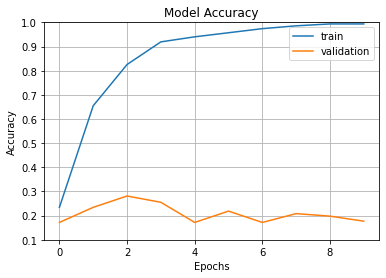

In [44]:
#plot the train and validation accuracy
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [63]:
#save the model
model.save('resnet.h5')

In [ ]:
from keras.models import load_model

# Load the trained ResNet model
model = load_model('resnet.h5')

# List of ASL letters (in label order)
ALPHABET_LIST = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's',
    't', 'u', 'v', 'w', 'x', 'y'
]

# Make predictions on the validation set
y_pred_probs = model.predict(X_val_rgb, verbose=0)  # shape (num_samples, 24)

# Get predicted labels (index of highest probability)
y_pred = np.argmax(y_pred_probs, axis=1)


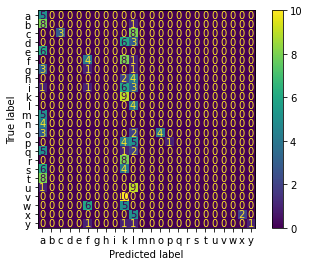

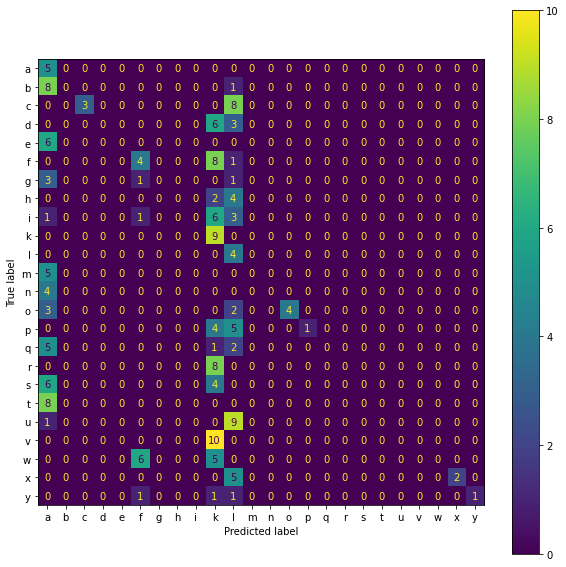

In [ ]:
#create confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay.from_predictions(onehot_encoded_val.argmax(axis=1), y_pred.argmax(axis=1),display_labels=ALPHABET_LIST)
# print(onehot_encoded_val.argmax(axis=1).shape)

fig, ax = plt.subplots(figsize=(10,10))
matrix.plot(ax=ax)